# This script is to calculate the distance to edge and conduct the spatial correlation analysis

[1. Import packages and files](#1-import-packages-and-files)  
[2. Calculate the distance to edge for each colony at each timepoint](#2-convex-hull-and-calculate-the-distance)  
[3. Spatial Correlation Coefficient and Data Cleaning](#3-spatial-correlation-coefficient-and-data-cleaning)  
[4. Plot](#4-plot)  
[5. Linear Mixed Effect Test](#5-linear-mixed-effect-test)

## 1. Import Packages and Files

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

# from alphashape import alphashape
# from shapely.geometry import Point, LineString, Polygon
# from shapely.ops import nearest_points

# from pyhull.delaunay import DelaunayTri
# from shapely.geometry import Polygon, LineString
# # from scipy.spatial import distance                                                                                                                         

In [ ]:
data_directory = '../Data/Distance_Results'

# result_directory = './04_Distance_Results'
# if not os.path.exists(result_directory):
#     os.makedirs(result_directory)
    

In [3]:
# Get a list of all CSV files in the directory
csv_files = glob.glob(data_directory + '/*.csv')

# Create an empty list to store the dataframes
dfs = []

# Iterate over each CSV file and read it into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate the dataframes into a single dataframe
combined_df = pd.concat(dfs)

df = combined_df.copy()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_34483/1735554683.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [4]:
df.groupby('gene').cluster.nunique()

gene
lasB    20
lasI    17
lasR    30
rpsL    29
Name: cluster, dtype: int64

In [5]:
# Load the datasets
df_all = pd.read_csv(os.path.join(result_directory, "all_results_clustered.csv"), low_memory=False)

# Inspect the first few rows to understand the structure of the data
df_all.head()

NameError: name 'result_directory' is not defined

## 2. Convex Hull and Calculate the Distance

In [20]:
# to test
# 测试点的坐标
x0 = np.array([1, 5, 3, 7])
y0 = np.array([1, 2, -1, -2])

# 直线的起点和终点
x1, y1 = 0, 0  # 直线的起点
x2, y2 = 10, 0  # 直线的终点

# 计算每个点到直线的距离
distances = getDist2Line(x0, y0, x1, y1, x2, y2)

# 打印结果
print("Points (x, y):")
for i in range(len(x0)):
    print(f"({x0[i]}, {y0[i]}) -> Distance to line: {distances[i]:.2f}")

Points (x, y):
(1, 1) -> Distance to line: 1.00
(5, 2) -> Distance to line: 2.00
(3, -1) -> Distance to line: 1.00
(7, -2) -> Distance to line: 2.00


In [4]:
def getDist2Line(x0, y0, x1, y1, x2, y2):
    '''
    to calculate the distance between a point and a line
    '''
    
    # initialize the distances array
    distances = np.full(len(x0), np.nan)
    
    # convert the coordinates to numpy arrays
    v = np.array([x1, y1])
    w = np.array([x2, y2])
    
    # calculate the squared length of the line
    l2 = (y2-y1)**2 + (x2-x1)**2
    
    for i in range(len(distances)):
        # current point
        p = np.array([x0[i], y0[i]])
        # calculate the projection parameter
        t = max(0, min(1, np.dot(p - v, w - v) / l2))
        # calculate the projection of the point on the line
        projection = v + t * (w - v)
        # calculate the distance between the point and the projection
        distances[i] = np.sqrt(np.sum((projection - p)**2))
    
    return distances

def getDist(x, y):
    temp = pd.DataFrame({'x': x, 'y': y})
    temp['dist.to.edge'] = 0

    try:
        # 使用 pyhull 的 DelaunayTri 进行三角剖分
        points = np.array([x, y]).T
        delaunay = DelaunayTri(points)

        # 提取外边界点
        edge_points = np.array([points[simplex] for simplex in delaunay.vertices]).reshape(-1, 2)

        # 如果没有足够的点形成边界，则返回全 0 的距离
        if len(edge_points) == 0:
            return temp['dist.to.edge']
        
        # 去除重复的边界点
        edge_points = np.unique(edge_points, axis=0)

        # 创建边界多边形
        hull = Polygon(edge_points)

        # 初始距离为第一个边界线段到每个点的距离
        old_dists = getDist2Line(temp['x'].values, temp['y'].values, edge_points[0, 0], edge_points[0, 1], edge_points[1, 0], edge_points[1, 1])

        # 计算每条边界线段到点的最小距离
        for i in range(len(edge_points) - 1):
            dists = getDist2Line(temp['x'].values, temp['y'].values, edge_points[i, 0], edge_points[i, 1], edge_points[i+1, 0], edge_points[i+1, 1])
            # 找出 dists 小于 old_dists 的位置
            smlr = dists < old_dists
            # 更新 old_dists，确保只更新那些 smlr 为 True 且 dists 不是 NaN 的位置
            old_dists[smlr & ~np.isnan(dists)] = dists[smlr & ~np.isnan(dists)]
        
        return old_dists
    except Exception as e:
        print(f"Error: {e}")
        return temp['dist.to.edge']  # 如果有任何异常，返回全 0 的距离


In [13]:
def getDist2Line(x0, y0, x1, y1, x2, y2):
    '''
    to calculate the distance between a point and a line
    '''
    
    # initialize the distances array
    distances = np.full(len(x0), np.nan)
    
    # convert the coordinates to numpy arrays
    v = np.array([x1, y1])
    w = np.array([x2, y2])
    
    # calculate the squared length of the line
    l2 = (y2-y1)**2 + (x2-x1)**2
    
    for i in range(len(distances)):
        # current point
        p = np.array([x0[i], y0[i]])
        # calculate the projection parameter
        t = max(0, min(1, np.dot(p - v, w - v) / l2))
        # calculate the projection of the point on the line
        projection = v + t * (w - v)
        # calculate the distance between the point and the projection
        distances[i] = np.sqrt(np.sum((projection - p)**2))
    
    return distances

def getDist(x, y):
    temp = pd.DataFrame({'x': x, 'y': y})
    temp['dist.to.edge'] = 0

    try:
        # 创建 alpha-shape
        points = np.array([x, y]).T
        alpha = 30
        hull = alphashape(points, alpha)

        
        print(hull)
        # 检查 hull 的类型是 Polygon 还是 LineString
        if isinstance(hull, Polygon):
            edge_points = np.array(hull.exterior.coords)
            print(edge_points)
        elif isinstance(hull, LineString):
            edge_points = np.array(hull.coords)
        else:
            return temp['dist.to.edge']  # 如果既不是 Polygon 也不是 LineString，返回全 0 的距离


        # 初始距离为第一个边界线段到每个点的距离
        old_dists = getDist2Line(temp['x'].values, temp['y'].values, edge_points[0, 0], edge_points[0, 1], edge_points[1, 0], edge_points[1, 1])
        #print(old_dists)

        # 计算每条边界线段到点的最小距离
        for i in range(len(edge_points) - 1):
            dists = getDist2Line(temp['x'].values, temp['y'].values, edge_points[i, 0], edge_points[i, 1], edge_points[i+1, 0], edge_points[i+1, 1])
            # 找出 dists 小于 old_dists 的位置
            smlr = dists < old_dists
            # 更新 old_dists，确保只更新那些 smlr 为 True 且 dists 不是 NaN 的位置
            old_dists[smlr & ~np.isnan(dists)] = dists[smlr & ~np.isnan(dists)]
        
        return old_dists

    except Exception as e:
        print(f"Error in calculating alpha-shape: {e}")
        return temp['dist.to.edge']


In [5]:
def analyze_and_plot(df):
    # Compute distances for each group and add as a new column
    def compute_distances(group):
        group = group.reset_index(drop=True)  # Reset index to avoid issues
        group['dist_to_edge'] = getDist(group['new_x'], group['new_y'])
        return group
    
    df = df.groupby(['frames', 'cluster']).apply(lambda group: compute_distances(group)).reset_index(drop=True)
    # df = df.groupby(['frames', 'cluster'], include_groups=False).apply(compute_distances).reset_index(drop=True)


    # # Add 'edge' column based on 'dist_to_edge'
    # df['edge'] = df['dist_to_edge'] == 0
    
    return df

In [6]:
# calculate the distances
df_dist = analyze_and_plot(df_all)

: 

ValueError: Could not interpret value `edge` for `style`. An entry with this name does not appear in `data`.

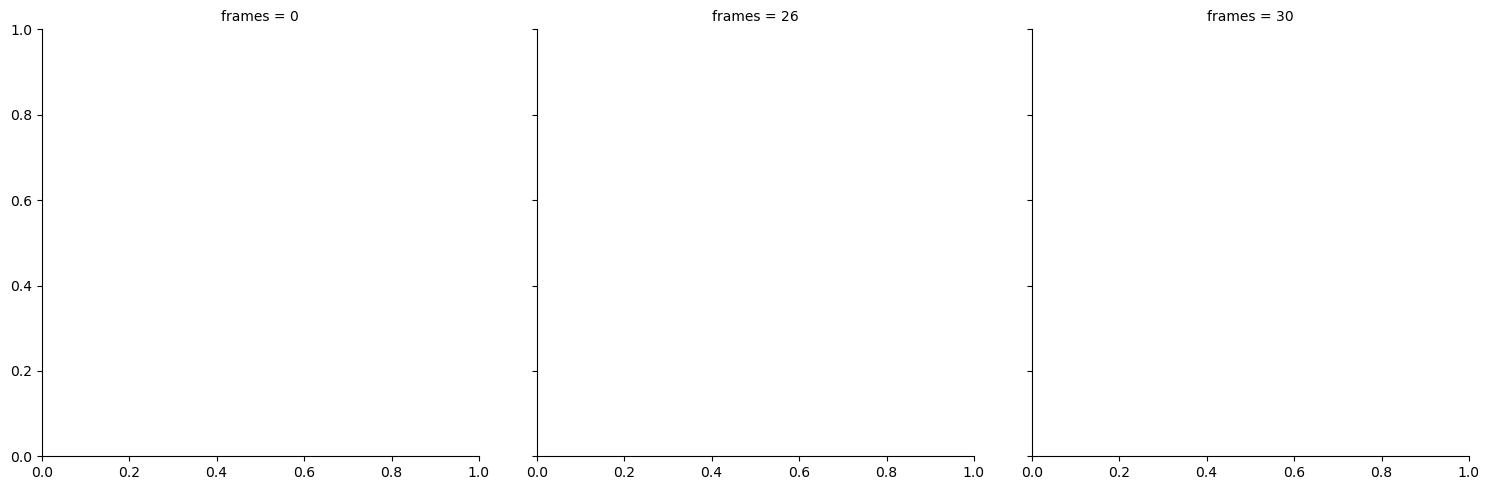

In [18]:
# check the edge points with plotting
df_test = df_dist[df_dist['cluster'] == 15].copy()

def visualize_edge_and_clustering(df):
    # Select specific frames for visualization
    t_snap = [df['frames'].min(), df['frames'].median(), df['frames'].max()]
    subset_df = df[df['frames'].isin(t_snap)]

    # Create a FacetGrid to create multiple plots based on 'frames'
    g = sns.FacetGrid(subset_df, col='frames', col_wrap=3, height=5, aspect=1)
    g.map_dataframe(sns.scatterplot, x='new_x', y='new_y', hue='dist_to_edge', style='edge', palette='viridis', markers={True: 'o', False: 'X'}, s=20, alpha=0.7)
    
    # Set axis labels and title
    g.set_axis_labels('x', 'y')
    g.set(xlim=(0, 2304), ylim=(0, 2304))
    g.set_titles(col_template="{col_name}")
    g.add_legend(title='Distance to Edge')

    plt.show()

# Example usage:
visualize_edge_and_clustering(df_test)

## 3. Spatial Correlation Coefficient and Data Cleaning

In [5]:
# if "2. Convex Hull and Calculate the Distance" does not work, import datafame from R
# Get a list of all CSV files in the directory
csv_files = glob.glob(data_directory + '/*.csv')

# Create an empty list to store the dataframes
dfs = []

# Iterate over each CSV file and read it into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate the dataframes into a single dataframe
combined_df = pd.concat(dfs)

df.dist = combined_df.copy()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_14881/878078347.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_14881/878078347.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.dist = combined_df.copy()


In [5]:
# rename coloumns
df = df.rename(columns={'dist.to.edge': 'dist_to_edge'}).copy()

# Replace null values in 'dist_to_edge' with 0
df.fillna({'dist_to_edge': 0}, inplace=True)
df['edge'] = df['dist_to_edge'] == 0

In [6]:
df_all = df.loc[df['Autoinducer'] == 'Without'].copy()
df_all['fluo3'] = df_all['fluo2'] / df_all['fluo1']

In [7]:
def calculate_group_correlation(group):
    # 计算每个组的 Pearson 相关系数
    if 'dist_to_edge' in group.columns and 'fluo2' in group.columns:
        if group[['dist_to_edge', 'fluo2']].isnull().values.any():
            print("Warning: NaN values found in 'dist_to_edge' or 'fluo2'.")
        correlation_mcherry = group[['dist_to_edge', 'fluo1']].corr().iloc[0, 1]
        correlation_gfp = group[['dist_to_edge', 'fluo2']].corr().iloc[0, 1]
        correlation_ngfp = group[['dist_to_edge', 'fluo3']].corr().iloc[0, 1]
    else:
        print("Error: 'dist_to_edge' or 'fluo2' columns not found in the group.")
        correlation_mcherry = float('nan')
        correlation_gfp = float('nan')
        correlation_ngfp = float('nan')
    group['correlation_coefficient_mcherry'] = correlation_mcherry
    group['correlation_coefficient_gfp'] = correlation_gfp
    group['correlation_coefficient_ngfp'] = correlation_ngfp
    return group

def add_group_correlation(df):
    # 按 'frames' 和 'AI_group' 分组，并计算每个组的相关系数
    df = df.groupby(['frames', 'cluster']).apply(calculate_group_correlation).reset_index(drop=True)
    return df


df_corr = add_group_correlation(df_all)

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_34483/1568735764.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['frames', 'cluster']).apply(calculate_group_correlation).reset_index(drop=True)


In [8]:
# remove rows with NaN values in 'correlation_coefficient_mcherry' or 'correlation_coefficient_gfp'
df_1 = df_corr.loc[~((df_corr.correlation_coefficient_mcherry.isna())|(df_corr.correlation_coefficient_gfp.isna())|(df_corr.correlation_coefficient_ngfp.isna()))].copy()

# check the value of 'correlation_coefficient_mcherry' and 'correlation_coefficient_gfp'
print(f"mcherry: {df_1.correlation_coefficient_mcherry.describe()} \n")
print(f"gfp: {df_1.correlation_coefficient_gfp.describe()} \n")
print(f"ngfp: {df_1.correlation_coefficient_ngfp.describe()}")

mcherry: count    86915.000000
mean         0.647014
std          0.131927
min         -0.941418
25%          0.561966
50%          0.659317
75%          0.770804
max          0.842677
Name: correlation_coefficient_mcherry, dtype: float64 

gfp: count    86915.000000
mean         0.640663
std          0.205835
min         -0.847702
25%          0.514983
50%          0.709955
75%          0.809650
max          0.914993
Name: correlation_coefficient_gfp, dtype: float64 

ngfp: count    86915.000000
mean         0.293894
std          0.451593
min         -0.948249
25%         -0.119833
50%          0.501363
75%          0.682288
max          0.970006
Name: correlation_coefficient_ngfp, dtype: float64


In [9]:
## check amount of colonies
print(f"amount of cells in colonies: {df_1.groupby(['frames', 'cluster']).correlation_coefficient_ngfp.count()}")

# filter the data for analysis
# at 8:00h
df_2 = df_1.loc[df_1['frames']==24].copy()

# from 4:00h to 8:00h
df_3 = df_1.loc[df_1['frames'].isin(range(16, 41))].copy()

amount of cells in colonies: frames  cluster
3       75.0          4
4       75.0          4
5       64.0          4
        75.0          4
        84.0          7
                   ... 
48      67.0        495
        68.0        454
        69.0       1027
        70.0        804
        72.0        808
Name: correlation_coefficient_ngfp, Length: 929, dtype: int64


In [10]:
# 在分组后保留 gene, frames, Autoinducer, series 列，但不使用它们作为列索引
pivoted_group = df_3.groupby(['cluster','frames', 'gene', 'Autoinducer', 'series']).agg(
    correlation_coefficient_mcherry = ('correlation_coefficient_mcherry', 'mean'),
    correlation_coefficient_gfp = ('correlation_coefficient_gfp', 'mean'),
    correlation_coefficient_ngfp = ('correlation_coefficient_ngfp', 'mean'),
    colony_size=('id', 'size')).reset_index()

pivoted_group

,cluster,frames,gene,Autoinducer,series,correlation_coefficient_mcherry,correlation_coefficient_gfp,correlation_coefficient_ngfp,colony_size
0,55.0,16,lasR,Without,20,0.497103,0.211716,-0.498827,13
1,55.0,17,lasR,Without,20,0.310616,0.298156,-0.136593,16
2,56.0,16,lasR,Without,20,0.630037,0.521402,-0.413993,28
3,56.0,17,lasR,Without,20,0.581907,0.507714,-0.395079,30
4,56.0,18,lasR,Without,20,0.619096,0.496919,-0.368118,32
...,...,...,...,...,...,...,...,...,...
577,95.0,27,lasB,Without,38,0.561966,0.614296,-0.377132,145
578,95.0,28,lasB,Without,38,0.550028,0.558829,-0.375733,192
579,96.0,16,lasB,Without,39,0.451594,0.595410,-0.295308,31
580,96.0,17,lasB,Without,39,0.429311,0.640763,-0.259835,32


In [11]:
pivoted_group.groupby(['gene','Autoinducer']).cluster.nunique()

gene  Autoinducer
lasB  Without         9
lasI  Without        10
lasR  Without        11
rpsL  Without        12
Name: cluster, dtype: int64

In [12]:
# 重塑DataFrame，方便绘制多个box plot
df_melted = pd.melt(pivoted_group, id_vars=['gene','frames','cluster','Autoinducer','colony_size'],
                    value_vars=['correlation_coefficient_mcherry', 'correlation_coefficient_gfp', 'correlation_coefficient_ngfp'], 
                    var_name='Fluorescent_Protein', value_name='Correlation_Coefficient')

df_melted = df_melted.replace({'correlation_coefficient_mcherry': 'mCherry', 'correlation_coefficient_gfp': 'GFP', 'correlation_coefficient_ngfp': 'nGFP'})
df_melted

,gene,frames,cluster,Autoinducer,colony_size,Fluorescent_Protein,Correlation_Coefficient
0,lasR,16,55.0,Without,13,mCherry,0.497103
1,lasR,17,55.0,Without,16,mCherry,0.310616
2,lasR,16,56.0,Without,28,mCherry,0.630037
3,lasR,17,56.0,Without,30,mCherry,0.581907
4,lasR,18,56.0,Without,32,mCherry,0.619096
...,...,...,...,...,...,...,...
1741,lasB,27,95.0,Without,145,nGFP,-0.377132
1742,lasB,28,95.0,Without,192,nGFP,-0.375733
1743,lasB,16,96.0,Without,31,nGFP,-0.295308
1744,lasB,17,96.0,Without,32,nGFP,-0.259835


In [13]:
df_melted.colony_size.describe()

count    1746.000000
mean       99.541237
std       102.481121
min        12.000000
25%        32.000000
50%        61.000000
75%       123.000000
max       615.000000
Name: colony_size, dtype: float64

## 4. Plot

In [14]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (12, 8)
    }
)

In [24]:
# catgorize the colony size
# bins = [0, 50, 150, 250, 500, float('inf')]
# labels = ['(0, 50)', '(50, 150)', '(150, 250)', '(250, 500)', '(>500)']
bins = [0, 50, 150, 250, 500]
labels = ['(0, 50)', '(50, 150)', '(150, 250)', '(250, 500)']

# Create the new column with categorized counts
df_melted['count_category'] = pd.cut(df_melted['colony_size'], bins=bins, labels=labels, right=False)
# df_melted_new = df_melted.loc[df_melted['Fluorescent_Protein'] == 'GFP'].copy()

In [25]:
df_melted.count_category.value_counts()

count_category
(50, 150)     735
(0, 50)       693
(150, 250)    168
(250, 500)    135
Name: count, dtype: int64

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_14881/2282825281.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['gene'] = pd.Categorical(filtered_df['gene'], categories=['lasI', 'lasR', 'lasB'], ordered=True)
/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_14881/2282825281.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = filtered_df.groupby('count_category')['cluster'].nunique()


Kruskal-Wallis results for (0, 50): H-statistic = 60.7925, p-value = 0.0000
Kruskal-Wallis results for (50, 150): H-statistic = 87.1486, p-value = 0.0000
Kruskal-Wallis results for (150, 250): H-statistic = 21.4866, p-value = 0.0000
Kruskal-Wallis results for (250, 500): H-statistic = 12.1000, p-value = 0.0024


/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_14881/2282825281.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=16)


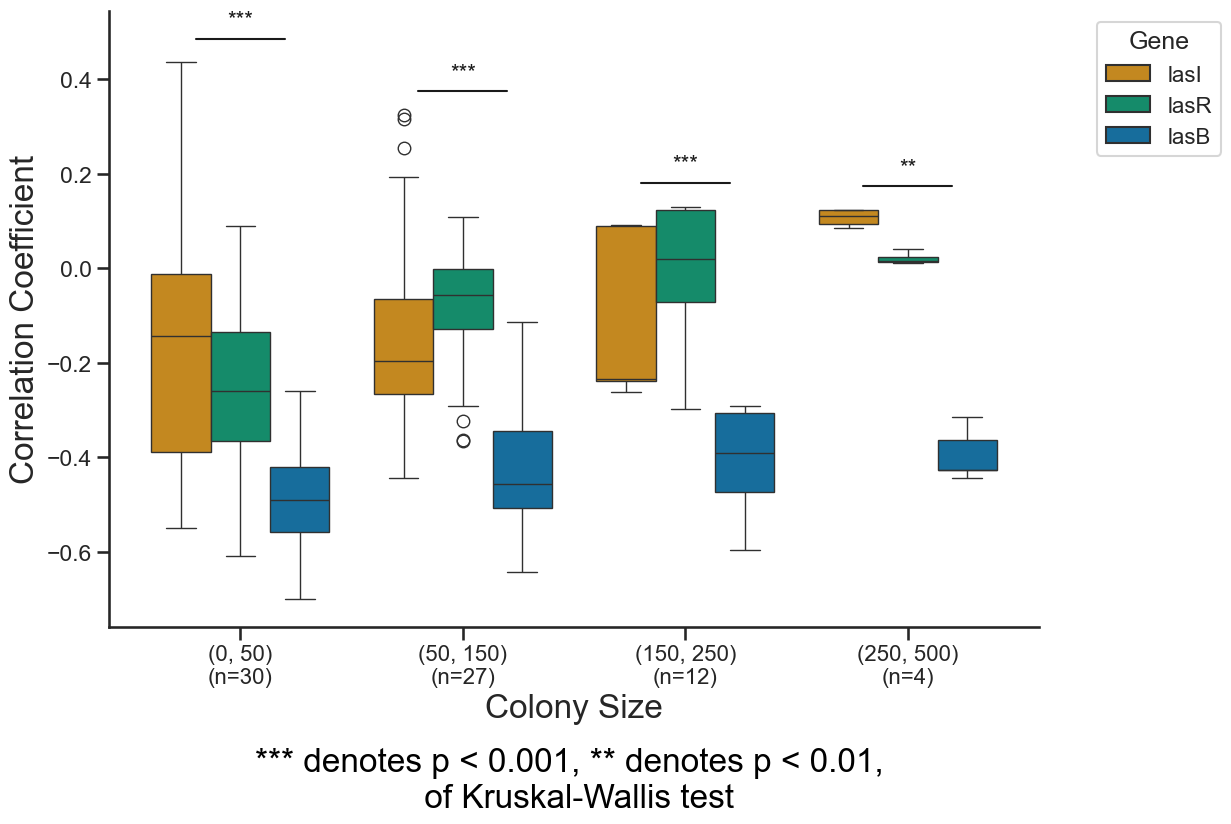

In [37]:
from scipy.stats import kruskal
# from scipy.stats import f_oneway

# boxplot of all las genes at different colony sizes of nGFP
df_melted_new = df_melted.loc[df_melted['Fluorescent_Protein'] == 'nGFP'].copy()

# Define custom colors for each gene
custom_palette = {'lasB': sns.color_palette("colorblind")[0], 
                  'lasI': sns.color_palette("colorblind")[1], 
                  'lasR': sns.color_palette("colorblind")[2]}

# Filter the DataFrame for the three specific genes
filtered_df = df_melted_new[df_melted_new['gene'].isin(['lasI', 'lasR', 'lasB'])]
# Set the desired order for the 'gene' column
filtered_df['gene'] = pd.Categorical(filtered_df['gene'], categories=['lasI', 'lasR', 'lasB'], ordered=True)

# Calculate the number of clusters in each count category
cluster_counts = filtered_df.groupby('count_category')['cluster'].nunique()

# Create custom x-axis labels with cluster counts
x_labels = [f"{cat}\n(n={cluster_counts[cat]})" for cat in cluster_counts.index]

# Create the boxplot
ax = sns.boxplot(x='count_category', y='Correlation_Coefficient', hue='gene', data=filtered_df, palette=custom_palette)

# Set the custom x-axis labels
ax.set_xticklabels(x_labels, fontsize=16)

# stat test
# Conduct ANOVA test for each count category
anova_results = {}
for category in cluster_counts.index:
    category_data = filtered_df[filtered_df['count_category'] == category]
    lasI_vals = category_data[category_data['gene'] == 'lasI']['Correlation_Coefficient']
    lasR_vals = category_data[category_data['gene'] == 'lasR']['Correlation_Coefficient']
    lasB_vals = category_data[category_data['gene'] == 'lasB']['Correlation_Coefficient']
    
    h_stat, p_val = kruskal(lasI_vals, lasR_vals, lasB_vals)
    anova_results[category] = {'h_stat': h_stat, 'p_val': p_val}
    print(f"Kruskal-Wallis results for {category}: H-statistic = {h_stat:.4f}, p-value = {p_val:.4f}")

# Add significance markers to the plot
for category, result in anova_results.items():
    if result['p_val'] < 0.001:
        significance = '***'
    elif result['p_val'] < 0.01:
        significance = '**'
    elif result['p_val'] < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # not significant

    x_pos = labels.index(category)
    y_max = filtered_df[filtered_df['count_category'] == category]['Correlation_Coefficient'].max()
    y = y_max + 0.05
    h = 0.02
    col = 'k'
    
    plt.plot([x_pos - 0.2, x_pos + 0.2], [y, y], lw=1.5, c=col)
    plt.text(x_pos, y + h, significance, ha='center', va='bottom', color=col, fontsize=16)

# Customize plot appearance
# plt.title('Correlation Coefficient by Colony Size (Las)', fontsize=20, pad=20)
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
# Increase the size of x-axis and y-axis labels
ax.set_xlabel('Colony Size', fontsize=24)
ax.set_ylabel('Correlation Coefficient', fontsize=24)

# # Increase the size of the legend labels
# plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)
plt.text(0.5, -0.25, '*** denotes p < 0.001, ** denotes p < 0.01, \n of Kruskal-Wallis test', ha='center', va='center', transform=ax.transAxes, fontsize=24, color='black')

# Display the plot
plt.show()


In [20]:
# boxplot of all las genes of GFP, to compare with housekeeping gene rpsL
df_melted_new = df_melted.loc[(df_melted['Fluorescent_Protein'] == 'nGFP') & (df_melted['gene'] != 'rpsL')].copy()
# Define custom colors for each gene
custom_palette = {'lasB': sns.color_palette("colorblind")[0], 
                  'lasI': sns.color_palette("colorblind")[1], 
                  'lasR': sns.color_palette("colorblind")[2],
                  'rpsL': sns.color_palette("colorblind")[3]}

In [21]:
# Conduct linear mixed effect model for statistical testing
import statsmodels.formula.api as smf

model = smf.mixedlm("Correlation_Coefficient ~  gene", data=df_melted_new, groups=df_melted_new["cluster"])
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Correlation_Coefficient
No. Observations: 353     Method:             REML                   
No. Groups:       30      Scale:              0.0135                 
Min. group size:  2       Log-Likelihood:     211.1127               
Max. group size:  20      Converged:          Yes                    
Mean group size:  11.8                                               
-----------------------------------------------------------------------
                   Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept          -0.435      0.051   -8.605   0.000   -0.534   -0.336
gene[T.lasI]        0.294      0.070    4.219   0.000    0.157    0.431
gene[T.lasR]        0.251      0.069    3.655   0.000    0.116    0.385
Group Var           0.022      0.057                                   



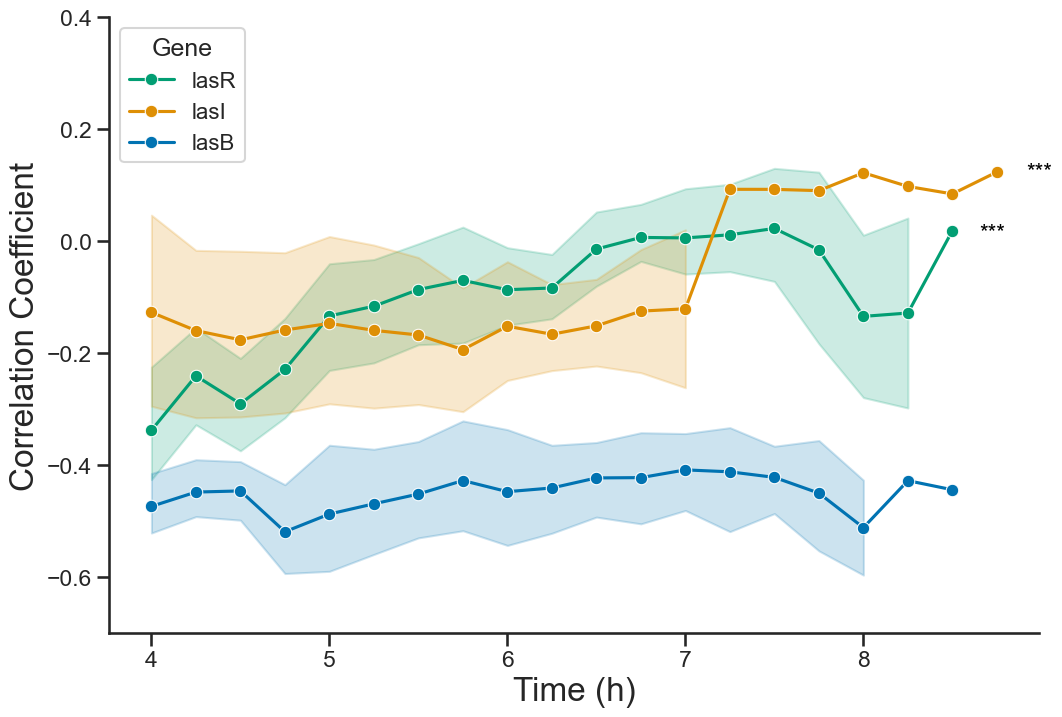

In [28]:
# Conduct linear mixed effect model for statistical testing
import statsmodels.formula.api as smf

df_melted_new['Time'] = df_melted_new['frames']*0.25
# Draw a line plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=df_melted_new, x='Time', y='Correlation_Coefficient', hue='gene', marker='o', palette=custom_palette)
plt.xlabel('Time (h)', fontsize=24)
plt.ylabel('Correlation Coefficient', fontsize=24)
# plt.title('Correlation Coefficient over Frames by Gene', fontsize=16)
plt.text(1, 0.75, '***', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')
plt.text(0.95, 0.65, '***', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')
# plt.text(0.5, -0.25, '*** denotes p < 0.001 for LMM', ha='center', va='center', transform=ax.transAxes, fontsize=24, color='black')
plt.legend(title='Gene', loc='upper left', fontsize=16)
plt.ylim(-0.7, 0.4)
plt.show()

Gene: rpsL, Shapiro-Wilk Test Stat: 0.8584, p-value: 0.0466
Gene: lasI, Shapiro-Wilk Test Stat: 0.8293, p-value: 0.0329
Gene: lasR, Shapiro-Wilk Test Stat: 0.9516, p-value: 0.7534
Gene: lasB, Shapiro-Wilk Test Stat: 0.9073, p-value: 0.3356


/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_34257/2695808853.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=16)


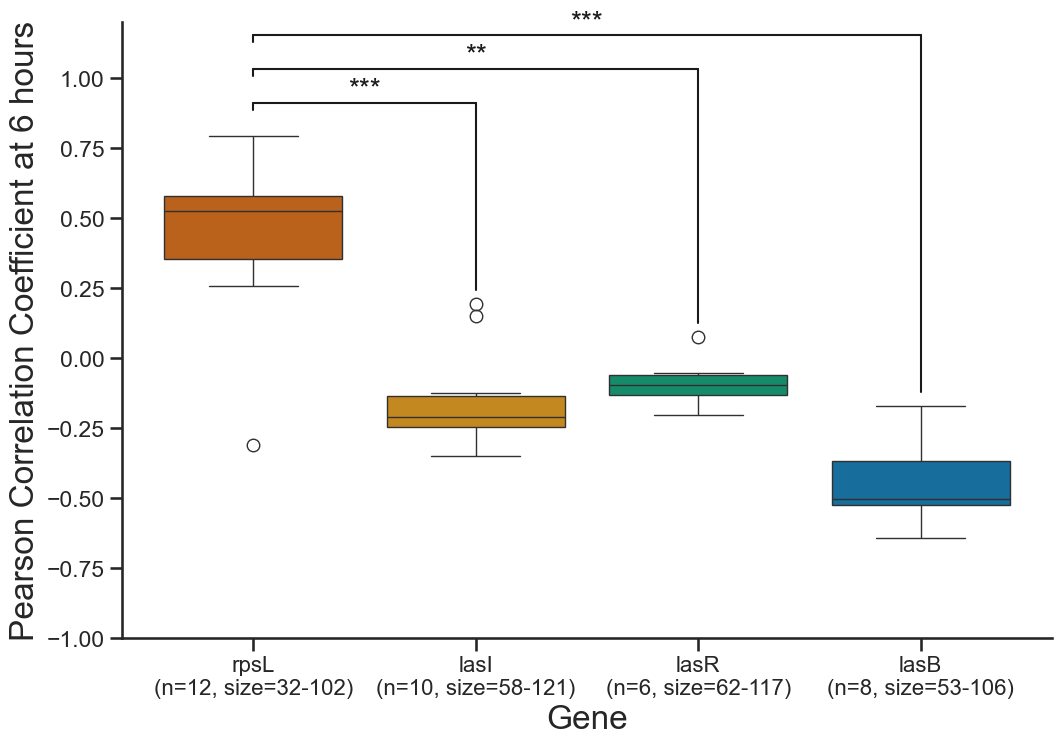

In [31]:
from scipy.stats import shapiro, mannwhitneyu

df_melted_gfp = df_melted.loc[(df_melted['Fluorescent_Protein'] == 'nGFP') & 
                              (df_melted['frames'] == 24)].copy()

# 计算每个gene对应的cluster数量, # 计算每个gene对应的cluster size区间
cluster_counts = df_melted_gfp.groupby('gene')['cluster'].nunique()
cluster_sizes = df_melted_gfp.groupby('gene').agg({'colony_size': ['min', 'max']})
cluster_sizes.columns = ['min_colony_size', 'max_colony_size']  # 重命名列

# Define gene order and create custom x labels
gene_order = ['rpsL', 'lasI', 'lasR', 'lasB']  # 自定义顺序（可以根据需要修改）
df_melted_gfp['gene'] = pd.Categorical(df_melted_gfp['gene'], categories=gene_order, ordered=True)

x_labels = [f"{gene}\n(n={cluster_counts[gene]}, size={cluster_sizes.loc[gene, 'min_colony_size']}-{cluster_sizes.loc[gene, 'max_colony_size']})"
            for gene in gene_order]


# 使用seaborn绘制box plot
ax = sns.boxplot(x='gene', y='Correlation_Coefficient', hue='gene', data=df_melted_gfp, palette=custom_palette)

# 设置x轴标签
ax.set_xticklabels(x_labels, fontsize=16)


non_normal_genes = []
gene_data = {gene: df_melted_gfp.loc[df_melted_gfp['gene'] == gene, 'Correlation_Coefficient'].dropna() 
             for gene in gene_order}

for gene, data in gene_data.items():
    stat, p = shapiro(data)  # Shapiro-Wilk test for normality
    if p < 0.05:  # 不符合正态分布
        non_normal_genes.append(gene)
    print(f"Gene: {gene}, Shapiro-Wilk Test Stat: {stat:.4f}, p-value: {p:.4f}")

# # Wilcoxon rank-sum test
# if len(non_normal_genes) > 1:
#     for i in range(len(non_normal_genes) - 1):
#         for j in range(i + 1, len(non_normal_genes)):
#             gene1 = non_normal_genes[i]
#             gene2 = non_normal_genes[j]
#             data1 = gene_data[gene1]
#             data2 = gene_data[gene2]
#             stat, p = wilcoxon(data1, data2)
#             print(f"Wilcoxon Test between {gene1} and {gene2}: Stat={stat:.4f}, p-value={p:.4f}")


if len(non_normal_genes) != 0:
    ## 分离 rpsL 数据
    rpsl_vals = gene_data['rpsL']

    # 初始化字典存储检验结果
    significance = {}

    i=1
    # 遍历其他基因
    for gene in gene_order:
        if gene == 'rpsL':
            continue
        gene_vals = gene_data[gene]
        t_stat, p_val = mannwhitneyu(rpsl_vals, gene_vals, alternative='two-sided')
        # significance[gene] = {'t_stat': t_stat, 'p_value': p_val}

        # 确定显著性水平
        if p_val < 0.001:
            significance[gene] = '***'
        elif p_val < 0.01:
            significance[gene] = '**'
        elif p_val < 0.05:
            significance[gene] = '*'
        else:
            significance[gene] = 'ns'  # 不显著

        # 添加星号到相应位置
        x1, x2 = gene_order.index('rpsL'), gene_order.index(gene)  # 两个box plot之间的距离
        y, h, col = df_melted_gfp[df_melted_gfp['gene'] == 'rpsL']['Correlation_Coefficient'].max() + 0.12*i, 0.001, 'k'
        y1, y2 = df_melted_gfp[df_melted_gfp['gene'] == gene]['Correlation_Coefficient'].max() + 0.05, y - 0.025
        
        i+=1
        
        plt.plot([x1, x2], [y, y], lw=1.5, c=col)
        plt.plot([x1, x1], [y, y2], lw=1.5, c=col)
        plt.plot([x2, x2], [y, y1], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, significance[gene], ha='center', va='bottom', color=col, fontsize=20)

# 添加图表标题和标签
# plt.title('Spatial Correlation Coefficient from 4:00h to 8:00h (Las)', pad=20, fontsize=26)
plt.ylim(-1, 1.2)
plt.xlabel('Gene',fontsize=24)
plt.ylabel('Pearson Correlation Coefficient at 6 hours',fontsize=24)
# plt.legend(title = 'Fluorescent_Protein', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
# Add a line to indicate that ** denotes p < 0.01 for t-test
# plt.text(0.5, -0.25, '*** denotes p < 0.001, ** denotes for p <0.01, \n of Mann-Whitney U test', ha='center', va='center', transform=ax.transAxes, fontsize=24, color='black')

sns.despine(top=True, right=True)


# 显示图表
plt.show()

In [108]:
gene_data

{'rpsL': 1287    0.739237
 1303    0.377716
 1328    0.792029
 1353    0.615808
 1378    0.516780
 1403    0.418228
 1420   -0.311462
 1445    0.255995
 1462    0.551086
 1475    0.532817
 1488    0.278091
 1502    0.566581
 Name: Correlation_Coefficient, dtype: float64,
 'lasI': 1516   -0.221191
 1526   -0.124082
 1537   -0.231744
 1548    0.192762
 1559   -0.203613
 1579   -0.311927
 1590   -0.171499
 1603   -0.349243
 1612   -0.249980
 1621    0.149636
 Name: Correlation_Coefficient, dtype: float64,
 'lasR': 1194   -0.102459
 1210    0.075299
 1220   -0.144820
 1238   -0.092031
 1257   -0.204994
 1273   -0.052327
 Name: Correlation_Coefficient, dtype: float64,
 'lasB': 1630   -0.504476
 1643   -0.505441
 1659   -0.409329
 1675   -0.587734
 1689   -0.506065
 1702   -0.642005
 1719   -0.252230
 1738   -0.172528
 Name: Correlation_Coefficient, dtype: float64}

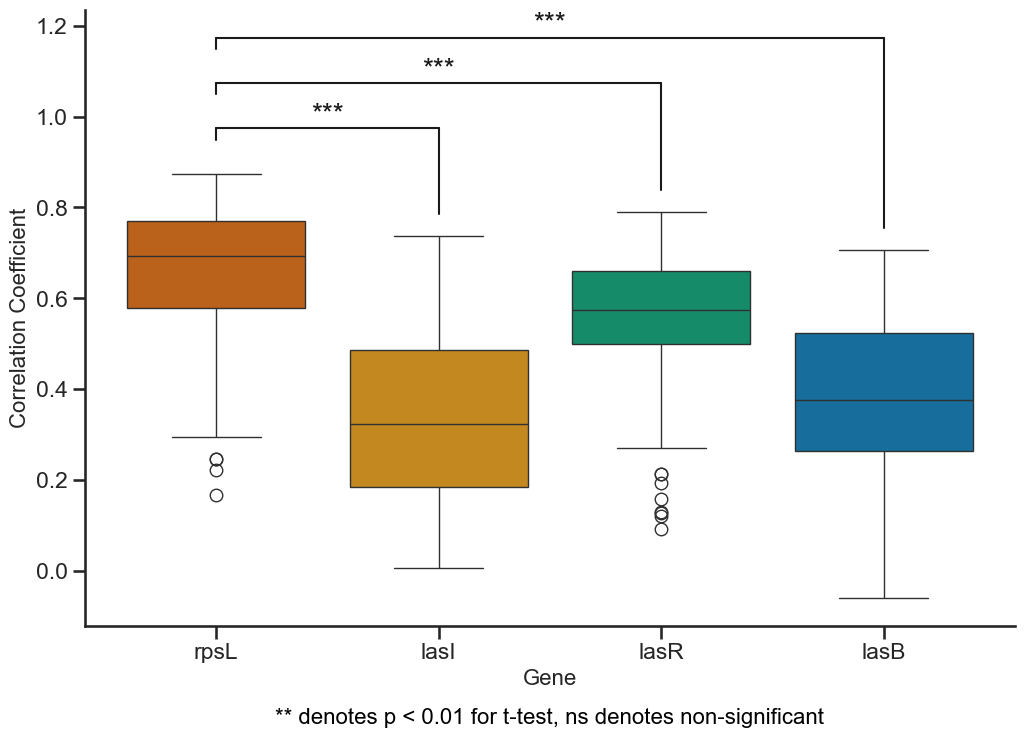

In [81]:
# 计算每个gene对应的cluster数量, # 计算每个gene对应的cluster size区间
cluster_counts = pivoted_group.groupby('gene')['cluster'].nunique()
cluster_sizes = pivoted_group.groupby('gene').agg({'colony_size': ['min', 'max']})
cluster_sizes.columns = ['min_colony_size', 'max_colony_size']  # 重命名列

# Define gene order and create custom x labels
gene_order = ['rpsL', 'lasI', 'lasR', 'lasB']  # 自定义顺序（可以根据需要修改）
df_melted_gfp['gene'] = pd.Categorical(df_melted_gfp['gene'], categories=gene_order, ordered=True)

x_labels = [f"{gene}\n(n={cluster_counts[gene]}, size={cluster_sizes.loc[gene, 'min_colony_size']}-{cluster_sizes.loc[gene, 'max_colony_size']})"
            for gene in gene_order]


# 使用seaborn绘制box plot
ax = sns.boxplot(x='gene', y='Correlation_Coefficient', hue='gene', data=df_melted_gfp, palette=custom_palette)

# # 设置x轴标签
# ax.set_xticklabels(x_labels, fontsize=16)
# ax.set_ylim(-0.9, 1.1)  # 设置y轴范围

# ax.axvline(0.5, color=".3", dashes=(2, 2))

# 分离 rpsL 数据
rpsl_vals = pivoted_group[pivoted_group['gene'] == 'rpsL']['correlation_coefficient_gfp']

# 初始化字典存储检验结果
significance = {}

i=1
# 遍历其他基因
for gene in gene_order:
    if gene == 'rpsL':
        continue
    gene_vals = pivoted_group[pivoted_group['gene'] == gene]['correlation_coefficient_gfp']
    t_stat, p_val = stats.ttest_ind(rpsl_vals, gene_vals)
    # significance[gene] = {'t_stat': t_stat, 'p_value': p_val}

    # 确定显著性水平
    if p_val < 0.001:
        significance[gene] = '***'
    elif p_val < 0.01:
        significance[gene] = '**'
    elif p_val < 0.05:
        significance[gene] = '*'
    else:
        significance[gene] = 'ns'  # 不显著

    # 添加星号到相应位置
    x1, x2 = gene_order.index('rpsL'), gene_order.index(gene)  # 两个box plot之间的距离
    y, h, col = df_melted_gfp[df_melted_gfp['gene'] == 'rpsL']['Correlation_Coefficient'].max() + 0.1*i, 0.001, 'k'
    y1, y2 = df_melted_gfp[df_melted_gfp['gene'] == gene]['Correlation_Coefficient'].max() + 0.05, y - 0.025
    
    i+=1
    
    plt.plot([x1, x2], [y, y], lw=1.5, c=col)
    plt.plot([x1, x1], [y, y2], lw=1.5, c=col)
    plt.plot([x2, x2], [y, y1], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, significance[gene], ha='center', va='bottom', color=col, fontsize=20)


# 添加图表标题和标签
# plt.title('Spatial Correlation Coefficient from 4:00h to 8:00h (Las)', pad=20, fontsize=26)
plt.xlabel('Gene',fontsize=16)
plt.ylabel('Correlation Coefficient',fontsize=16)
# plt.legend(title = 'Fluorescent_Protein', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
# Add a line to indicate that ** denotes p < 0.01 for t-test
plt.text(0.5, -0.15, '** denotes p < 0.01 for t-test, ns denotes non-significant', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')

sns.despine(top=True, right=True)


# 显示图表
plt.show()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_98438/3434532981.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=16)


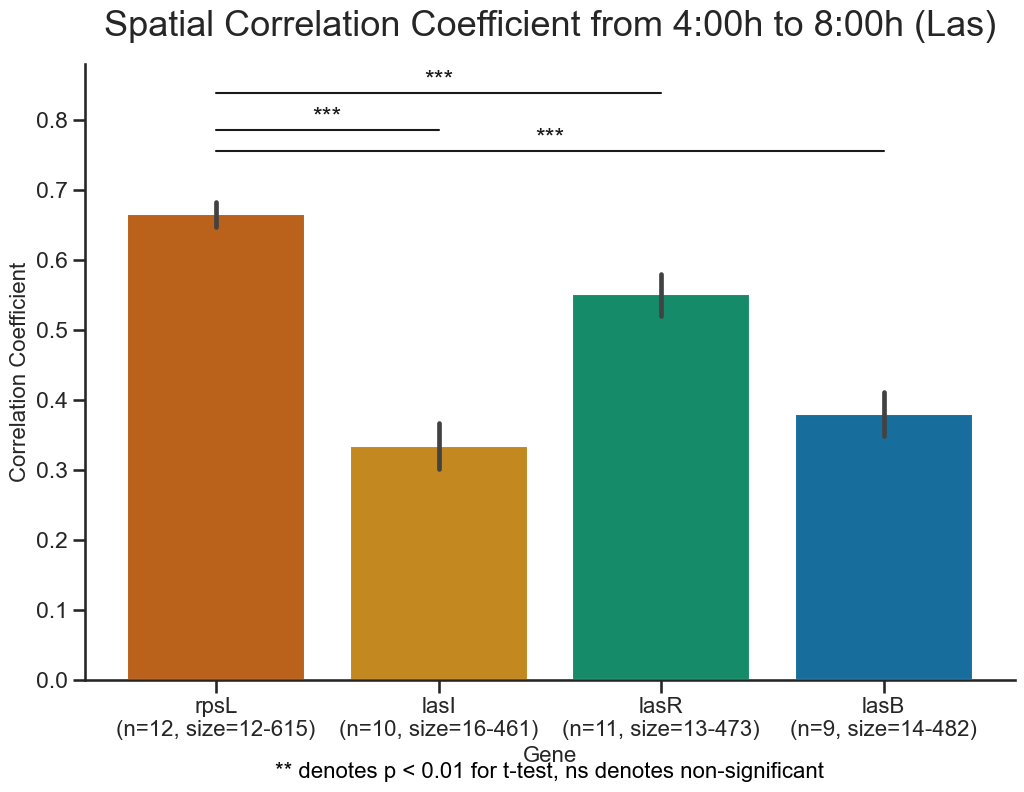

In [58]:
# 计算每个gene对应的cluster数量, # 计算每个gene对应的cluster size区间
cluster_counts = pivoted_group.groupby('gene')['cluster'].nunique()
cluster_sizes = pivoted_group.groupby('gene').agg({'colony_size': ['min', 'max']})
cluster_sizes.columns = ['min_colony_size', 'max_colony_size']  # 重命名列

# Define gene order and create custom x labels
gene_order = ['rpsL', 'lasI', 'lasR', 'lasB']  # 自定义顺序（可以根据需要修改）
df_melted_gfp['gene'] = pd.Categorical(df_melted_gfp['gene'], categories=gene_order, ordered=True)

x_labels = [f"{gene}\n(n={cluster_counts[gene]}, size={cluster_sizes.loc[gene, 'min_colony_size']}-{cluster_sizes.loc[gene, 'max_colony_size']})"
            for gene in gene_order]


# 使用seaborn绘制box plot
ax = sns.barplot(x='gene', y='Correlation_Coefficient', hue='gene', data=df_melted_gfp, palette=custom_palette)

# 设置x轴标签
ax.set_xticklabels(x_labels, fontsize=16)
# ax.set_ylim(-0.9, 1.1)  # 设置y轴范围

# ax.axvline(0.5, color=".3", dashes=(2, 2))

# 分离 rpsL 数据
rpsl_vals = pivoted_group[pivoted_group['gene'] == 'rpsL']['correlation_coefficient_gfp']

# 初始化字典存储检验结果
significance = {}

# 遍历其他基因
for gene in pivoted_group['gene'].unique():
    if gene == 'rpsL':
        continue
    gene_vals = pivoted_group[pivoted_group['gene'] == gene]['correlation_coefficient_gfp']
    t_stat, p_val = stats.ttest_ind(rpsl_vals, gene_vals)
    # significance[gene] = {'t_stat': t_stat, 'p_value': p_val}

    # 确定显著性水平
    if p_val < 0.001:
        significance[gene] = '***'
    elif p_val < 0.01:
        significance[gene] = '**'
    elif p_val < 0.05:
        significance[gene] = '*'
    else:
        significance[gene] = 'ns'  # 不显著

    # 添加星号到相应位置
    x1, x2 = gene_order.index('rpsL'), gene_order.index(gene)  # 两个box plot之间的距离
    y, h, col = df_melted_gfp[df_melted_gfp['gene'] == gene]['Correlation_Coefficient'].max() + 0.05, 0.001, 'k'
    
    plt.plot([x1, x2], [y, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, significance[gene], ha='center', va='bottom', color=col)


# 添加图表标题和标签
plt.title('Spatial Correlation Coefficient from 4:00h to 8:00h (Las)', pad=20, fontsize=26)
plt.xlabel('Gene',fontsize=16)
plt.ylabel('Correlation Coefficient',fontsize=16)
# plt.legend(title = 'Fluorescent_Protein', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
# Add a line to indicate that ** denotes p < 0.01 for t-test
plt.text(0.5, -0.15, '** denotes p < 0.01 for t-test, ns denotes non-significant', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')

sns.despine(top=True, right=True)


# 显示图表
plt.show()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_98397/3925517752.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=16)


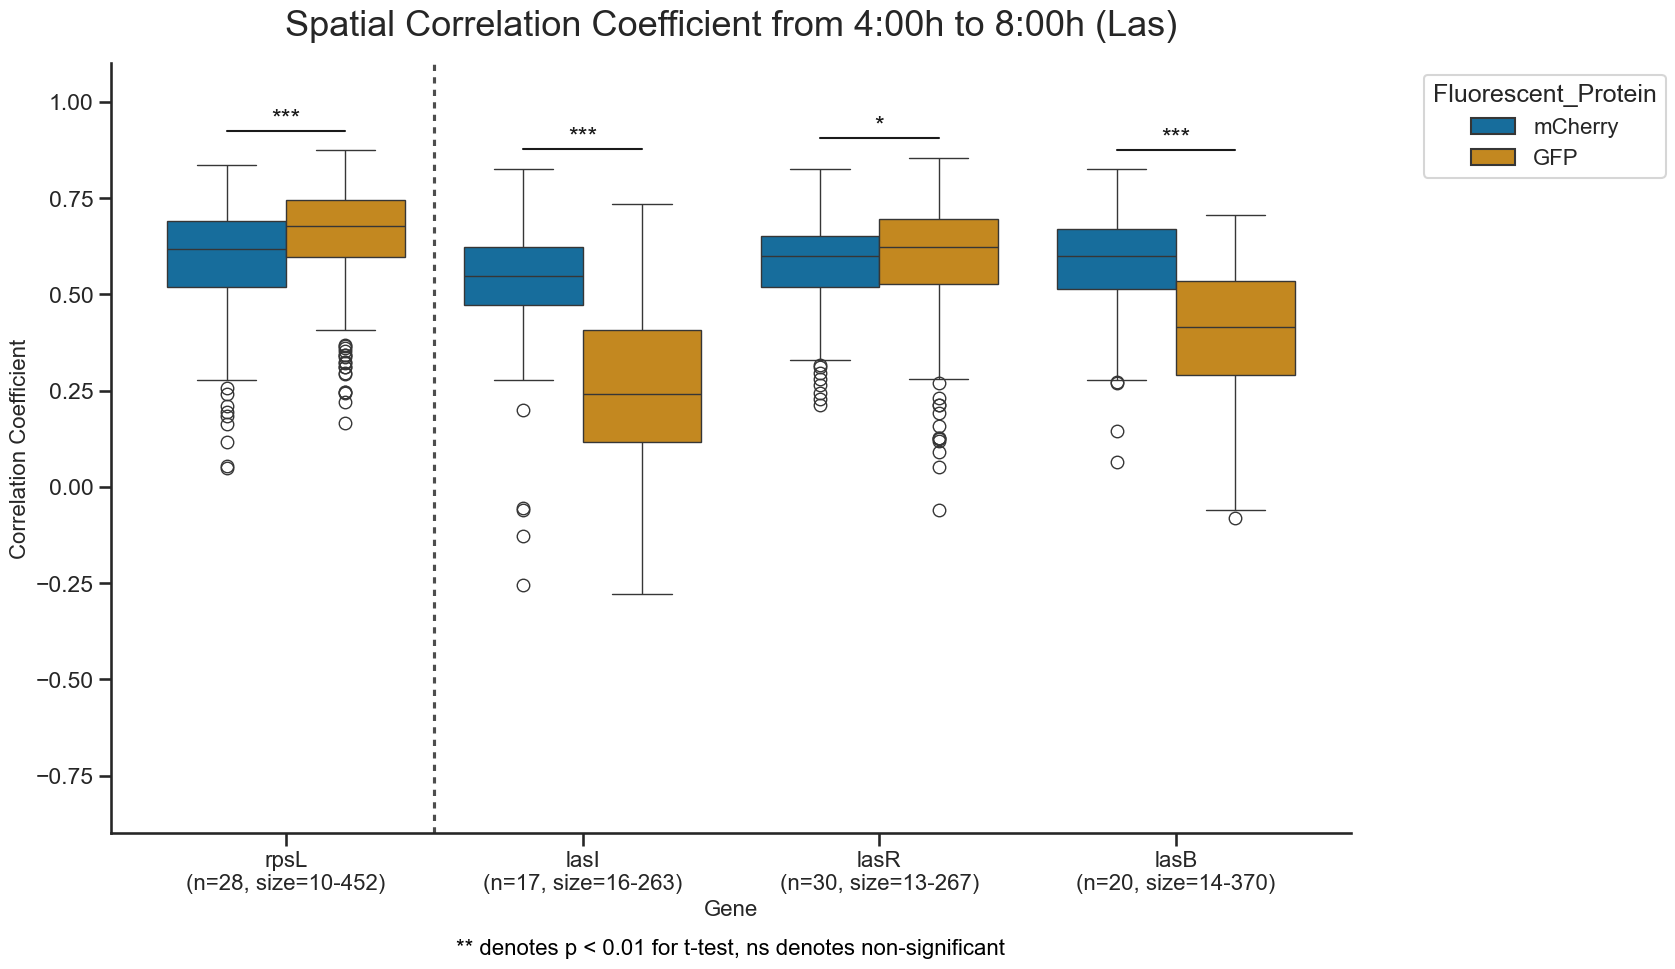

In [17]:
sns.set(style='ticks', palette='colorblind', context='talk')
# colors = sns.color_palette("colorblind")[2:4]

# 计算每个gene对应的cluster数量, # 计算每个gene对应的cluster size区间
cluster_counts = pivoted_group.groupby('gene')['cluster'].nunique()
cluster_sizes = pivoted_group.groupby('gene').agg({'colony_size': ['min', 'max']})
cluster_sizes.columns = ['min_colony_size', 'max_colony_size']  # 重命名列

# Define gene order and create custom x labels
gene_order = ['rpsL', 'lasI', 'lasR', 'lasB']  # 自定义顺序（可以根据需要修改）
df_melted['gene'] = pd.Categorical(df_melted['gene'], categories=gene_order, ordered=True)

x_labels = [f"{gene}\n(n={cluster_counts[gene]}, size={cluster_sizes.loc[gene, 'min_colony_size']}-{cluster_sizes.loc[gene, 'max_colony_size']})"
            for gene in gene_order]


# 使用seaborn绘制box plot
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='gene', y='Correlation_Coefficient', hue='Fluorescent_Protein', data=df_melted, palette='colorblind')

# # Manually adjust transparency by setting face color for each box patch
# for i, patch in enumerate(ax.patches):
#     # Set alpha to 0.5 for each patch (box)
#     facecolor = patch.get_facecolor()
#     patch.set_facecolor((facecolor[0], facecolor[1], facecolor[2], 0.5))
    

# 设置x轴标签
ax.set_xticklabels(x_labels, fontsize=16)
ax.set_ylim(-0.9, 1.1)  # 设置y轴范围

ax.axvline(0.5, color=".3", dashes=(2, 2))

# 进行t-test并添加显著性标记
significance = {}  # 存储每个gene的显著性

for gene in gene_order:
    # 提取该基因的GFP和mCherry的相关系数
    mcherry_vals = pivoted_group[pivoted_group['gene'] == gene]['correlation_coefficient_mcherry']
    gfp_vals = pivoted_group[pivoted_group['gene'] == gene]['correlation_coefficient_gfp']
    
    # 执行t-test
    t_stat, p_val = stats.ttest_ind(mcherry_vals, gfp_vals)
    
    # 确定显著性水平
    if p_val < 0.001:
        significance[gene] = '***'
    elif p_val < 0.01:
        significance[gene] = '**'
    elif p_val < 0.05:
        significance[gene] = '*'
    else:
        significance[gene] = 'ns'  # 不显著

    # 添加星号到相应位置
    x1, x2 = gene_order.index(gene) - 0.2, gene_order.index(gene) + 0.2  # 两个box plot之间的距离
    y, h, col = df_melted[df_melted['gene'] == gene]['Correlation_Coefficient'].max() + 0.05, 0.001, 'k'
    
    plt.plot([x1, x2], [y, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, significance[gene], ha='center', va='bottom', color=col)

# 添加图表标题和标签
plt.title('Spatial Correlation Coefficient from 4:00h to 8:00h (Las)', pad=20, fontsize=26)
plt.xlabel('Gene',fontsize=16)
plt.ylabel('Correlation Coefficient',fontsize=16)
plt.legend(title = 'Fluorescent_Protein', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
# Add a line to indicate that ** denotes p < 0.01 for t-test
plt.text(0.5, -0.15, '** denotes p < 0.01 for t-test, ns denotes non-significant', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')

sns.despine(top=True, right=True)


# 显示图表
plt.show()

## 5. Linear Mixed Effect test

In [34]:
import statsmodels.formula.api as smf

df_rpsl = df_melted.loc[df_melted['gene'] == 'rpsL']
df_lasI = df_melted.loc[df_melted['gene'] == 'lasI']
df_lasR = df_melted.loc[df_melted['gene'] == 'lasR']
df_lasB = df_melted.loc[df_melted['gene'] == 'lasB']

# 假设你有一个DataFrame 'df'，其中 'correlation_coefficient' 是响应变量
model = smf.mixedlm("Correlation_Coefficient ~ Fluorescent_Protein", 
                     data=df_lasR, 
                     groups=df_lasR["cluster"])

result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Correlation_Coefficient
No. Observations:   734      Method:              REML                   
No. Groups:         30       Scale:               0.0094                 
Min. group size:    4        Log-Likelihood:      616.7062               
Max. group size:    34       Converged:           Yes                    
Mean group size:    24.5                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.589    0.019 30.396 0.000  0.551  0.627
Fluorescent_Protein[T.mCherry] -0.024    0.007 -3.339 0.001 -0.038 -0.010
Group Var                       0.010    0.031                           



In [239]:
# Fit a null model without the fixed effect (Fluorescent_Protein)
null_model = smf.mixedlm("Correlation_Coefficient ~ 1", 
                         data=df_rpsl, 
                         groups=df_rpsl["cluster"])
null_result = null_model.fit()

# Perform a likelihood ratio test
lr_test = 2 * (result.llf - null_result.llf)  # Likelihood ratio statistic
p_value = 1 - stats.chi2.cdf(lr_test, df=1)   # Get the p-value with 1 degree of freedom

print(f"Likelihood Ratio Test statistic: {lr_test}")
print(f"P-value: {p_value}")


Likelihood Ratio Test statistic: 66.35180735281892
P-value: 3.3306690738754696e-16


/Users/liulaura/opt/anaconda3/envs/image2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [40]:
# Main effects model
model = smf.mixedlm("Correlation_Coefficient ~ gene + Autoinducer + count_category", 
                    data=df_melted_new, 
                    groups=df_melted_new["cluster"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Correlation_Coefficient
No. Observations:   2322    Method:             REML                   
No. Groups:         95      Scale:              0.0302                 
Min. group size:    6       Log-Likelihood:     635.1344               
Max. group size:    44      Converged:          Yes                    
Mean group size:    24.4                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.314    0.028 11.212 0.000  0.259  0.369
gene[T.lasI]                 -0.067    0.038 -1.772 0.076 -0.142  0.007
gene[T.lasR]                  0.206    0.033  6.179 0.000  0.140  0.271
gene[T.rpsL]                  0.255    0.034  7.624 0.000  0.190  0.321
Autoinduc

In [251]:
# Fit a null model without the fixed effect (Fluorescent_Protein)
test_model = smf.mixedlm("Correlation_Coefficient ~ Fluorescent_Protein", 
                         data=df_melted, 
                         groups=df_melted["cluster"])
test_result = null_model.fit()

# Perform a likelihood ratio test
lr_test = 2 * (result.llf - test_result.llf)  # Likelihood ratio statistic
p_value = 1 - stats.chi2.cdf(lr_test, df=1)   # Get the p-value with 1 degree of freedom

print(f"Likelihood Ratio Test statistic: {lr_test}")
print(f"P-value: {p_value}")


Likelihood Ratio Test statistic: 178.87194792006267
P-value: 0.0


In [134]:
df_melted_new.frames.describe()

count    582.000000
mean      23.682131
std        5.711388
min       16.000000
25%       19.000000
50%       23.000000
75%       27.000000
max       40.000000
Name: frames, dtype: float64

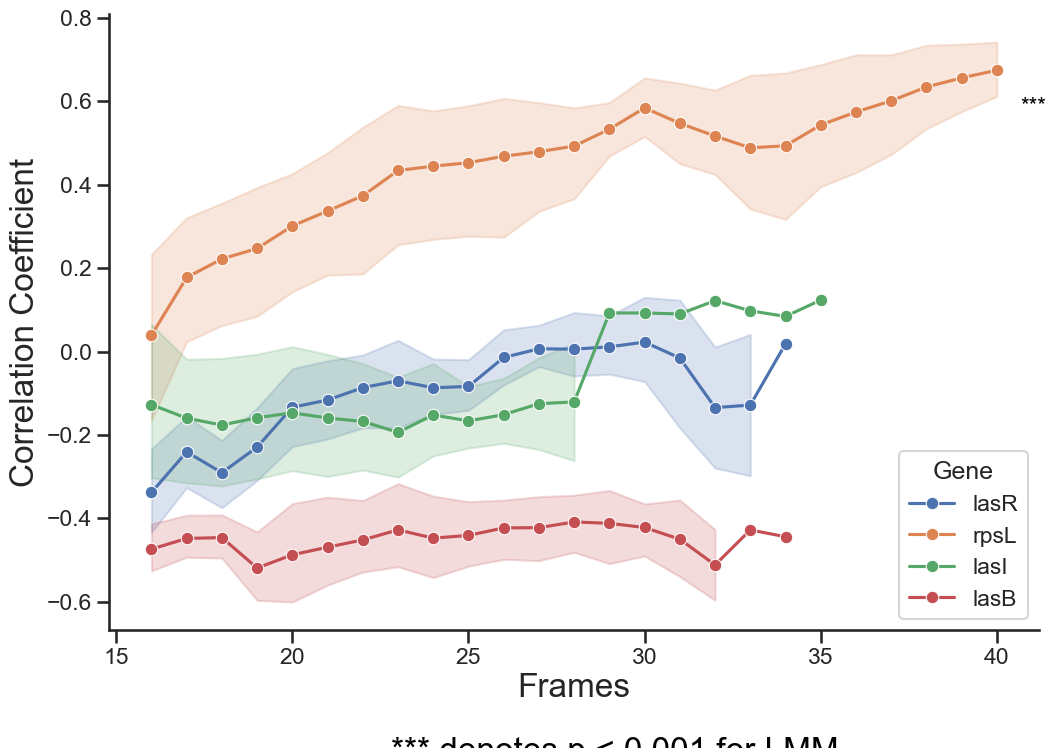

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Correlation_Coefficient
No. Observations: 582     Method:             REML                   
No. Groups:       42      Scale:              0.0149                 
Min. group size:  2       Log-Likelihood:     308.7030               
Max. group size:  25      Converged:          Yes                    
Mean group size:  13.9                                               
----------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept              -0.547     0.078  -7.061  0.000  -0.699  -0.395
gene[T.lasI]            0.143     0.114   1.257  0.209  -0.080   0.367
gene[T.lasR]           -0.023     0.109  -0.216  0.829  -0.237   0.190
gene[T.rpsL]            0.338     0.097   3.500  0.000   0.149   0.527
frames                  0.005

In [ ]:
# Conduct linear mixed effect model for statistical testing
import statsmodels.formula.api as smf

# Draw a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_melted_new, x='frames', y='Correlation_Coefficient', hue='gene', marker='o')
plt.xlabel('Frames', fontsize=24)
plt.ylabel('Correlation Coefficient', fontsize=24)
# plt.title('Correlation Coefficient over Frames by Gene', fontsize=16)
plt.text(0.95, 0.9, '***', ha='center', va='center', transform=ax.transAxes, fontsize=16, color='black')
plt.text(0.5, 0.1, '*** denotes p < 0.001 for LMM', ha='center', va='center', transform=ax.transAxes, fontsize=24, color='black')
plt.legend(title='Gene')
plt.show()

# # Conduct linear mixed effect model for statistical testing
# model = smf.mixedlm("Correlation_Coefficient ~ frames * gene", data=df_melted_new, groups=df_melted_new["cluster"])
# result = model.fit()
# print(result.summary())